In [1]:
using Luxor, Revise
W = 400; H= 400;
nPopulations::Int = 11

mutable struct Population
    S::Float64
    I::Float64
    R::Float64
    size::Float64
    position::Point
    index::Int
end

k_bar::Int = 4
α::Float64 = 0.1 # recovery rate
β::Float64 = 0.3 # internal population infection rate
μ::Float64 = 0.05 # internal population infection rate

0.05

In [2]:
function initializePopulations!(populations)
    r = W/2 - 30
    for i in 1:nPopulations
        theta = 2*π/nPopulations * i
        populations[i] = Population(1, 0, 0, 1, Point(r*cos(theta), r*sin(theta)), i)
    end
    populations[1].S=.9;
    populations[1].I=.1;
    
end


function fillConnectionMatrix!(connections::Array{Float64, 2}, nPopulations::Int, k_bar)
    for i in 1:nPopulations
        columns = [mod(i+j-1, nPopulations)+1 for j in -k_bar÷2:k_bar÷2 if mod(i+j-1, nPopulations)+1 != i]
        connections[i, columns] .= 1
    end
end

function updatePopulation!(pop::Population,localConnections::Array{Float64, 1},populations)
    S = pop.S; I = pop.I; R = pop.R
    totalExternalInfectionRate = 0
    for (index, connectionStrength) in enumerate(localConnections)
        if connectionStrength > 0
            totalExternalInfectionRate += connectionStrength * μ * populations[index].I
        end
    end
    dS = -(β*I+totalExternalInfectionRate)*S
    dI = (β*I+totalExternalInfectionRate)*S - α*I
    dR = α*I

    # integration
    pop.S += dS
    pop.I += dI
    pop.R += dR
end

function updateNetwork!(populations, connections)
    # Make a copy of all the populations
    populations_copy = deepcopy(populations)

    # Update each population
    for (i, population_copy) in enumerate(populations_copy)
       updatePopulation!(population_copy, connections[i,:],populations_copy)

        populations[i] = population_copy
    end
end

function drawPopulation(pop::Population)
    # Calculate the fractions
    total = pop.S + pop.I + pop.R
    s_fraction = pop.S / total
    i_fraction = pop.I / total
    r_fraction = pop.R / total
    radius = sqrt(pop.size)*15

    translate(pop.position)
    # rotate(-π/2)

    # setline(1)
    sethue("green")
    s_frac_radius = radius*sqrt(s_fraction)
    circle(O,s_frac_radius,:fill)

    sethue("red")
    # sector(0,radius, 2*π * s_fraction, 2*π * (s_fraction + i_fraction), :fill)
    i_frac_radius = radius*sqrt(i_fraction)
    circle(O,i_frac_radius,:fill)

    sethue("blue")
    # sector(0,radius, 2*π * (s_fraction + i_fraction), 2*π, :fill)
    r_frac_radius = radius * sqrt(r_fraction)
    circle(O,r_frac_radius,:fill)

    origin()
end

function drawConnections(populations,connections)
    setline(2) # Set line width
    sethue("black") # Set line color
    for i in 1:nPopulations
        for j in i:nPopulations
            if connections[i,j] == 1
                line(populations[i].position, populations[j].position, :stroke)
            end
        end
    end
end

function draw_network(populations,connections)
    @png begin
        origin()
        drawConnections(populations,connections)
        for pop in populations
            drawPopulation(pop)
        end
        finish()
    end 400 400 "MetaPopNet.png"
end

draw_network (generic function with 1 method)

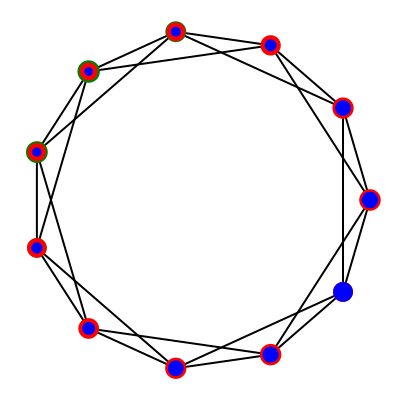

In [3]:
populations::Array{Population, 1} = Array{Population, 1}(undef, nPopulations)
connections::Array{Float64, 2} = zeros(Float64, nPopulations, nPopulations)

initializePopulations!(populations)
fillConnectionMatrix!(connections,nPopulations, k_bar)

for i in 1:15
    updateNetwork!(populations, connections)
end

draw_network(populations,connections)